Demonstration of the recent paper about CMB analysis

1. Load the library

In [3]:
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
from astropy.io import fits
import math
from astropy import units as u
from astropy.cosmology import Planck15
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import pymaster as nmt
#from system_config import ASSETS_DIRECTORY
import camb
from pathlib import Path
import requests
from scipy.linalg import sqrtm

2. Directory name and file name

In [2]:
# CMB data
Planck_cmb_path = '/home/yunan/COM_CMB_IQU-nilc_2048_R3.00_full.fits'
Planck_cmb_map = hp.read_map(Planck_cmb_path, field=0)*1e6


# Noise data
# For Planck's observations
planck_obs_fn = "{instrument}_SkyMap_{frequency}_{obs_nside}_{rev}_full.fits"

# For Planck's Simulated Noise Maps
planck_noise_fn_template = "ffp10_noise_{frequency}_{ring_cut}_map_mc_{realization}.fits"
url_template_sims = "http://pla.esac.esa.int/pla/aio/product-action?SIMULATED_MAP.FILE_ID={fn}"

# For Half-Mission Maps
hm_map_fn_template = "{instrument}_SkyMap_{freq}_2048_R3.01_halfmission-{hm}.fits"
url_template_maps = "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID={fn}"

def format_freq(freq):
    return "{:.0f}".format(freq).zfill(3)

def format_real(real):
    return "{:.0f}".format(real).zfill(5)

def get_map_data(fn, source_url_template):
    """Load map data from a file, downloading it if necessary."""
    dest_path = Path(ASSETS_DIRECTORY) / fn
    need_to_dl = False
    if not dest_path.exists():
        print(f"File {dest_path} does not exist; downloading.")
        need_to_dl = True
    elif dest_path.stat().st_size < 1024:  # If the file is less than 1KB, it's a placeholder file
        print(f"File {dest_path} has placeholder file; redownloading.")
        need_to_dl = True
    else:
        print(f"File {dest_path} exists.")
    if need_to_dl:
        response = requests.get(source_url_template.format(fn=fn))
        with open(fn, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {fn}")

In [ ]:
random_matrix = ([1,2],[3,4])
random_matrix_sqrt = np.zeros_like(random_matrix, dtype=np.complex128)
random_matrix_sqrt = sqrtm(random_matrix)
print(random_matrix_sqrt)
print(np.dot(random_matrix_sqrt,random_matrix_sqrt))

[[0.55368857+0.46439416j 0.80696073-0.21242648j]
 [1.21044109-0.31863972j 1.76412966+0.14575444j]]
[[1.+3.99655008e-17j 2.-1.40143451e-16j]
 [3.-4.45821695e-17j 4.+2.06644826e-18j]]


In [49]:
print(random_matrix)

([1, 2], [3, 4])


In [44]:
new_matrix = np.zeros((2,2))
for i in range(2):
    for j in range(2):
        new_matrix[i][j] = np.sqrt(random_matrix[i][j])
print(new_matrix)
print(np.dot(new_matrix,new_matrix))

[[1.         1.41421356]
 [1.73205081 2.        ]]
[[3.44948974 4.24264069]
 [5.19615242 6.44948974]]


Noise Table from Planck

In [2]:
# All white noise levels from Planck 2018 I, Table 4
WHITE_NOISE_LEVELS = {  # in $\\mu $K_CMB deg (I'm not sure how to handle the degrees part)
    30: 2.5,
    44: 2.7,
    70: 3.5,
    100: 1.29,
    143: 0.55,
    217: 0.78,
    353: 2.56,
    545: 0.78,  # In kJy / sr
    857: 0.72,  # In kJy / sr
}

CENTER_FREQS = {
    30: 28.4,      # Value from Planck DeltaBandpassTable & Planck 2018 I, Table 4
    44: 44.1,      # Value from Planck DeltaBandpassTable & Planck 2018 I, Table 4
    70: 70.4,      # Value from Planck DeltaBandpassTable & Planck 2018 I, Table 4
    100: 100.89,   # Value from Planck DeltaBandpassTable
    143: 142.876,  # Value from Planck DeltaBandpassTable
    217: 221.156,  # Value from Planck DeltaBandpassTable
    353: 357.5,    # Value from Planck DeltaBandpassTable
    545: 555.2,    # Value from Planck DeltaBandpassTable
    857: 866.8,    # Value from Planck DeltaBandpassTable
}

The relationship betweem resolution of a pixel and $N_{side}$ (This is the same as Healpy nside2reso fucntion)

In [2]:
def nside2radiant(nside):
    theta_rad = np.sqrt(4*np.pi/(12*nside**2))
    return theta_rad

In [5]:
# Convert resolution in arcmin to ellmax
def arcmin2ell(arcmin):
    ell = 10800/(arcmin)
    return int(ell)

In [8]:
arcmin2ell(5)

2160

Nomarlization

In [4]:
def cl2dl(cl, lmin, lmax):
    l = np.arange(lmin, lmax+1)
    dl = cl * l * (l + 1) / 2 / np.pi
    return dl

def dl2cl(dl, lmin, lmax):
    l = np.arange(lmin, lmax+1)
    cl = dl * 2 * np.pi / l / (l + 1)
    return cl

Generate a theory power spectrum using CAMB

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


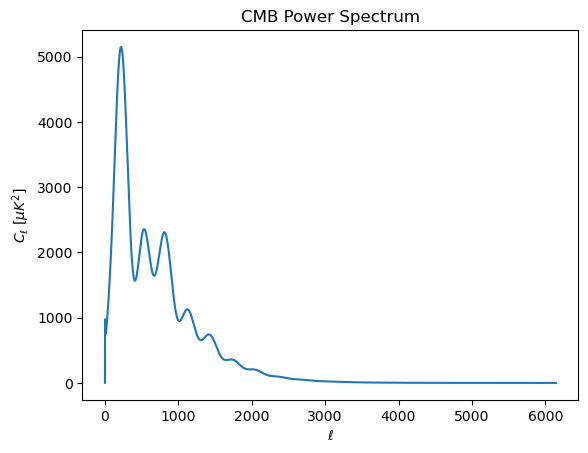

In [4]:
# Generate a CMB power spectrum
nside = 2048
ellmin = 0  # ell = 0, 1 are omitted
ellmax = 3*nside - 1
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
pars.set_for_lmax(ellmax)  # Ensure ellmax is set correctly
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', lmax=ellmax)

for name in powers:
    print(name)

totCL = powers['total']
ell = np.arange(totCL.shape[0])
plt.plot(ell[ellmin:], totCL[ellmin:, 0])
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$ [$\mu K^2$]')
plt.title('CMB Power Spectrum')
plt.show()

In [5]:
unlensed_cls = powers['unlensed_scalar']
unlensed_cls.shape

(6144, 4)

In [8]:
unlensed_cls

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 9.75314578e+02,  4.03868838e-02,  0.00000000e+00,
         2.91689328e+00],
       ...,
       [ 1.48958605e-02,  1.59181898e-04,  0.00000000e+00,
        -3.20399617e-06],
       [ 1.48831486e-02,  1.58552563e-04,  0.00000000e+00,
        -3.66002036e-06],
       [ 1.48705861e-02,  1.57924014e-04,  0.00000000e+00,
        -4.10770619e-06]])

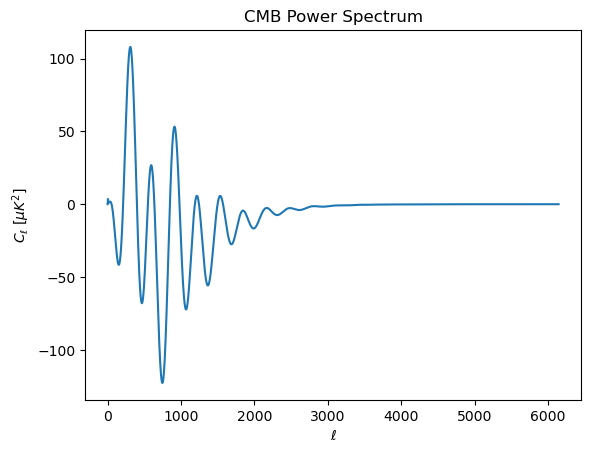

In [12]:
plt.plot(ell[ellmin:], totCL[ellmin:, 3], label='Total')
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$ [$\mu K^2$]')
plt.title('CMB Power Spectrum')
plt.show()

Convert the theory ps to a map realisation

In [9]:
cls = np.zeros(ellmax+1)
cls = dl2cl(totCL[ellmin:, 0], ellmin, ellmax)
map_realisation = hp.synfast(cls, nside=nside, new=True)

Visulaize the map

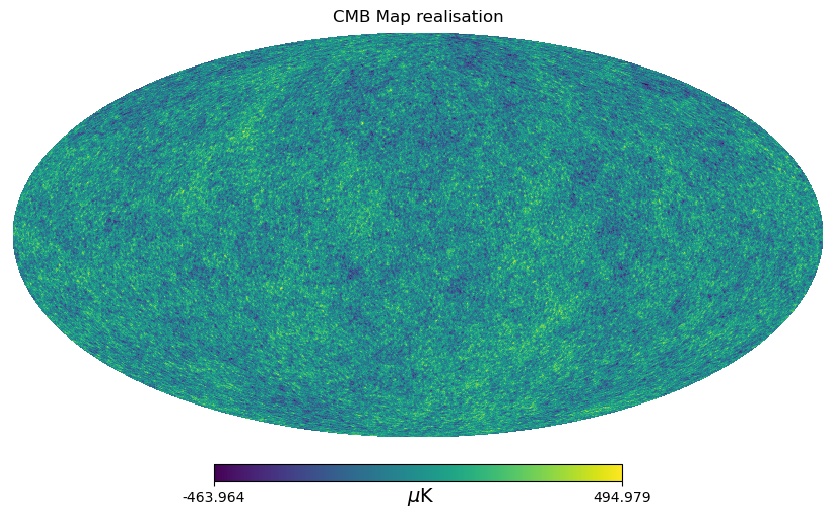

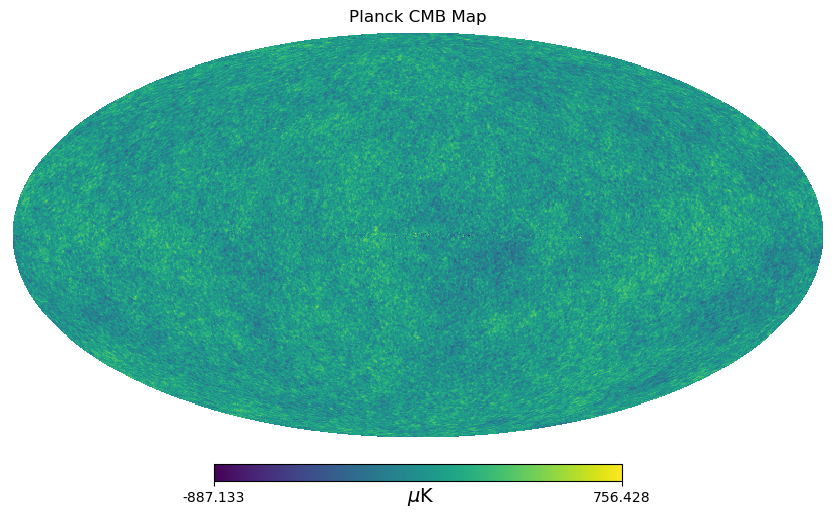

In [56]:
hp.mollview(map_realisation, title="CMB Map realisation", unit=" $\\mu$K")
hp.mollview(Planck_cmb_map, title="Planck CMB Map", unit=" $\\mu$K")

Calculate Power spectrum of the map realisation

    a. Healpy ANAFAST

    b. Pymaster Compute_full_master


In [11]:
# anafast
cls_from_map = hp.anafast(map_realisation, lmax=ellmax)
dls_from_map = np.zeros(ellmax+1)
dls_from_map = cl2dl(cls_from_map[ellmin:], ellmin, ellmax)

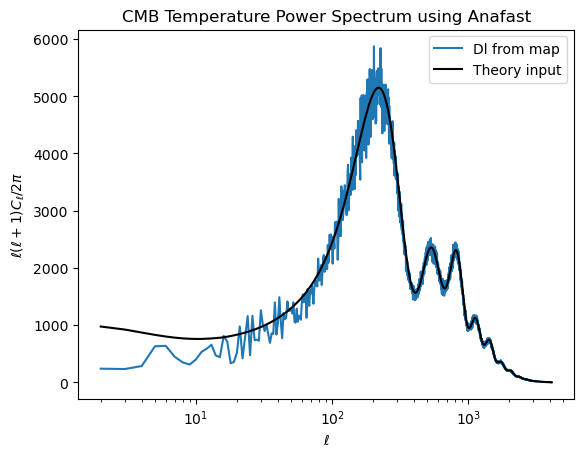

In [12]:
plt.plot(ell[ellmin:], dls_from_map, label = 'Dl from map')
plt.plot(ell[ellmin:], totCL[ellmin:, 0], c = 'black',label = 'Theory input')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell (\ell + 1) C_\ell / 2\pi$')
plt.xscale('log')
plt.title("CMB Temperature Power Spectrum using Anafast")
plt.legend()
plt.show()

Apply beam smoothing

In [13]:
def arcmin2rad(arcmin):
    return arcmin * np.pi / 180 / 60

def rad2arcmin(rad):
    return rad * 180 * 60 / np.pi

In [14]:
smooth_fwhm = 5 # arcmin
fwhm = arcmin2rad(smooth_fwhm)
smooth_fwhm_new = 40 # arcmin
fwhm_new = arcmin2rad(smooth_fwhm_new)
map_realisation_smooth = hp.smoothing(map_realisation, fwhm=fwhm, lmax = ellmax)
map_realisation_smooth_new = hp.smoothing(map_realisation, fwhm=fwhm_new, lmax = ellmax)

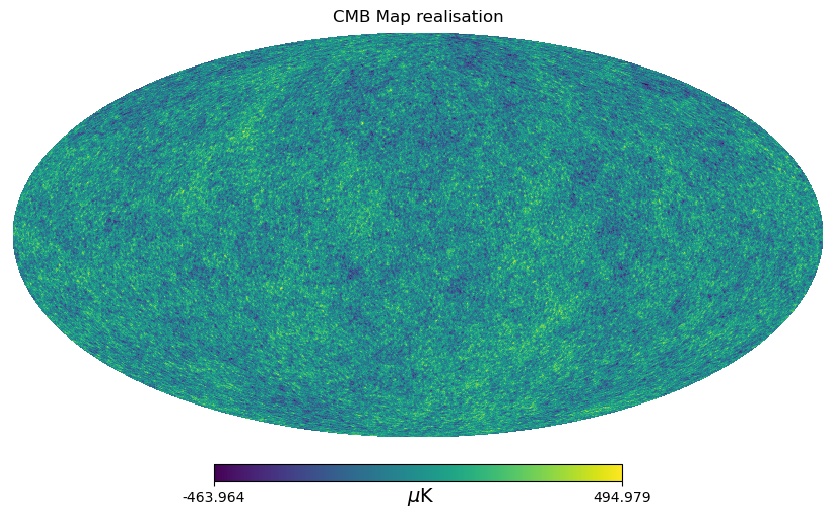

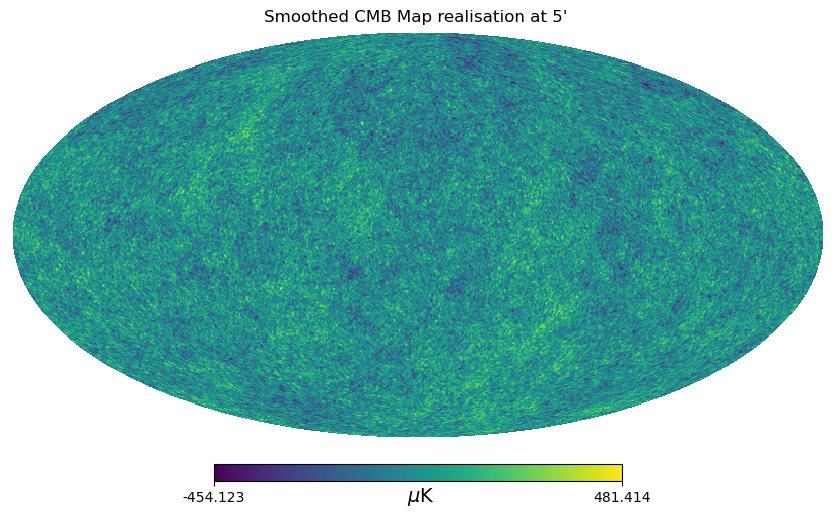

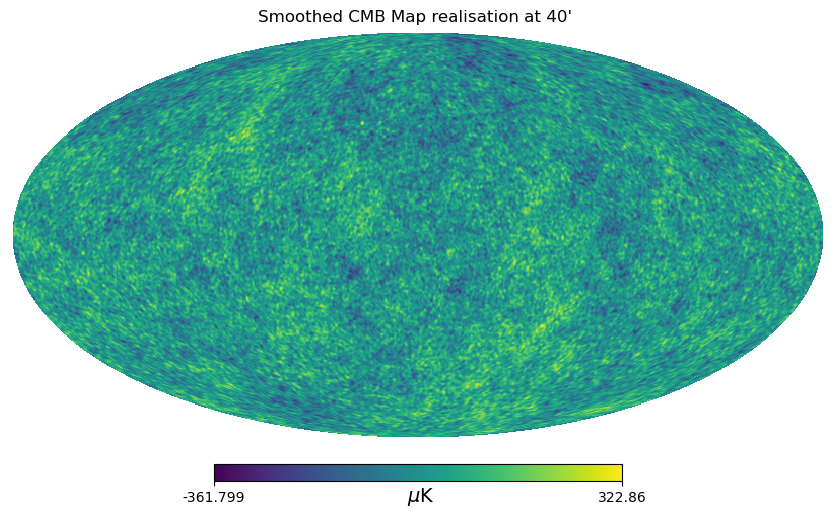

In [15]:
hp.mollview(map_realisation, title="CMB Map realisation", unit=" $\\mu$K")
hp.mollview(map_realisation_smooth, title="Smoothed CMB Map realisation at 5' ", unit=" $\\mu$K")
hp.mollview(map_realisation_smooth_new, title="Smoothed CMB Map realisation at 40' ", unit=" $\\mu$K")

Without correcting the beam

In [16]:
cl_5 = hp.anafast(map_realisation_smooth, lmax=ellmax)
cl_40 = hp.anafast(map_realisation_smooth_new, lmax=ellmax)
dl_5 = cl2dl(cl_5[ellmin:], ellmin, ellmax)
dl_40 = cl2dl(cl_40[ellmin:], ellmin, ellmax)

With beam correction

In [17]:
bl_5 = hp.gauss_beam(fwhm, lmax = ellmax)
bl_40 = hp.gauss_beam(fwhm_new, lmax = ellmax)
dl_5_corr = dl_5 /bl_5[ellmin:]**2
dl_40_corr = dl_40 /bl_40[ellmin:]**2

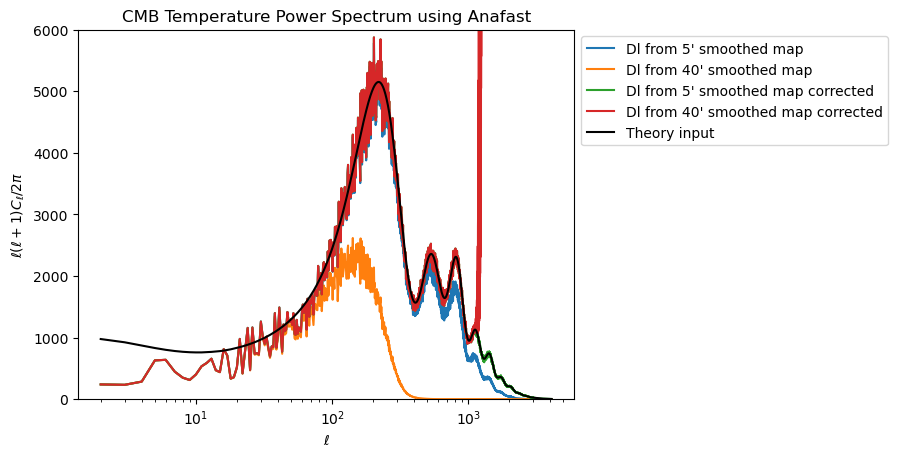

In [18]:
plt.plot(ell[ellmin:], dl_5, label = 'Dl from 5\' smoothed map')
plt.plot(ell[ellmin:], dl_40, label = 'Dl from 40\' smoothed map')
plt.plot(ell[ellmin:], dl_5_corr, label = 'Dl from 5\' smoothed map corrected')
plt.plot(ell[ellmin:], dl_40_corr, label = 'Dl from 40\' smoothed map corrected')
plt.plot(ell[ellmin:], totCL[ellmin:, 0], c = 'black',label = 'Theory input')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell (\ell + 1) C_\ell / 2\pi$')
plt.xscale('log')
plt.ylim(0, 6000)
plt.title("CMB Temperature Power Spectrum using Anafast")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Add mask to the map

In [19]:
mask = hp.read_map('/home/yunan/planck_release/planck_mask.fits')

Apodize the mask. This is processed by pymaster and can be mannually done.

In [20]:
aposcale = 0.5 # degrees
aposcale_new = 5 # degrees
mask_c1 = nmt.mask_apodization(mask, aposcale, apotype='C1')
mask_c1_new = nmt.mask_apodization(mask, aposcale_new, apotype='C1')

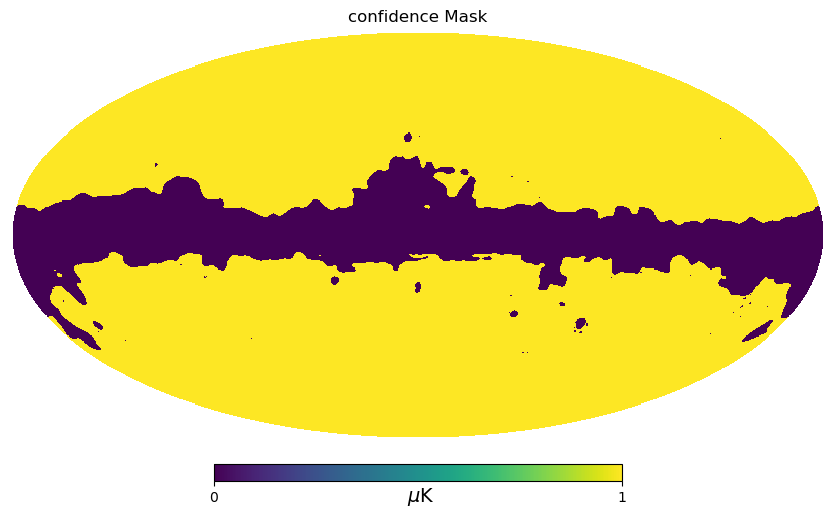

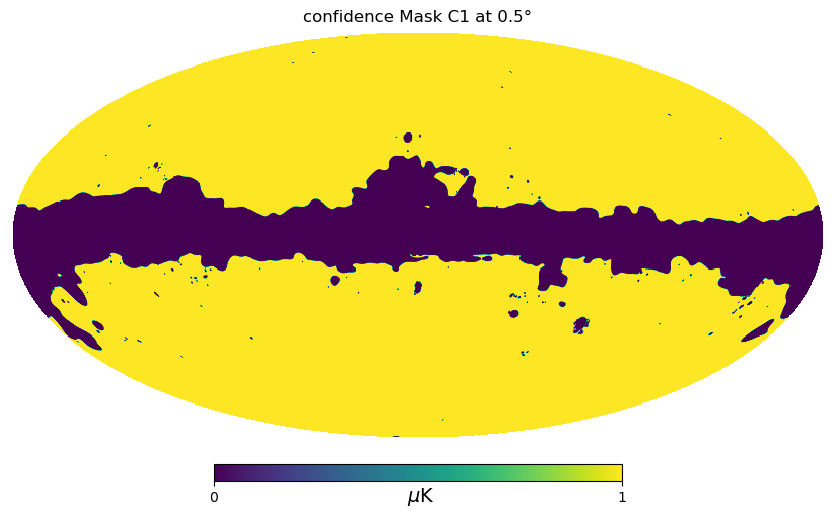

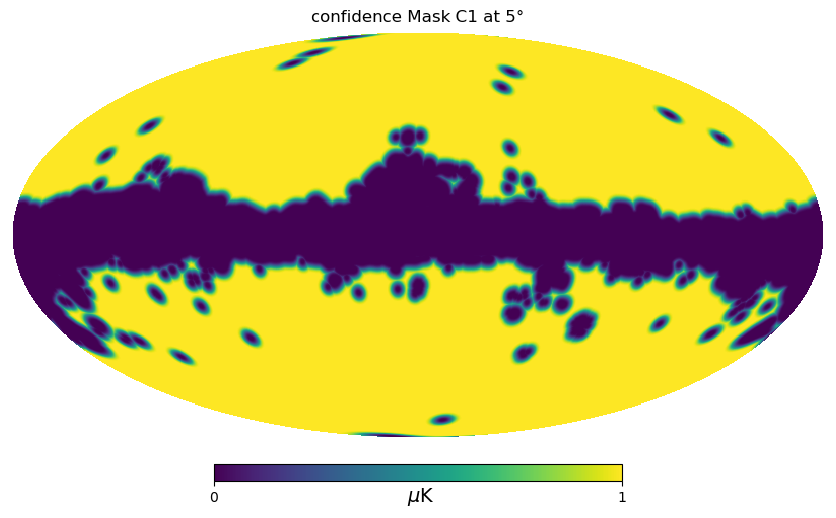

In [21]:
degree_symbol = "\u00B0"

hp.mollview(mask, title="confidence Mask", unit=" $\\mu$K")
hp.mollview(mask_c1, title=f"confidence Mask C1 at 0.5{degree_symbol}", unit=" $\\mu$K")
hp.mollview(mask_c1_new, title=f"confidence Mask C1 at 5{degree_symbol}", unit=" $\\mu$K")

In [22]:
map_masked = map_realisation * mask
map_apodized_masked = map_realisation * mask_c1
map_apodized_masked_new = map_realisation * mask_c1_new

Fraction of sky are masked out

In [23]:
fsky_mask = 1/(12*nside**2) *np.sum(mask**2)
fsky_mask_c1 = 1/(12*nside**2) *np.sum(mask_c1**2)
fsky_mask_c1_new = 1/(12*nside**2) *np.sum(mask_c1_new**2)
print(f"fsky = {fsky_mask_c1_new}")

fsky = 0.6669718888004402


In [24]:
cl_masked = hp.anafast(map_masked, lmax=ellmax)/fsky_mask
cl_apodized_masked = hp.anafast(map_apodized_masked, lmax=ellmax)/fsky_mask_c1
cl_apodized_masked_new = hp.anafast(map_apodized_masked_new, lmax=ellmax)/fsky_mask_c1_new

In [25]:
ratio = cls_from_map/ cls_from_map
ratio_1 = cl_masked / cls_from_map
ratio_2 = cl_apodized_masked / cls_from_map
ratio_3 = cl_apodized_masked_new / cls_from_map

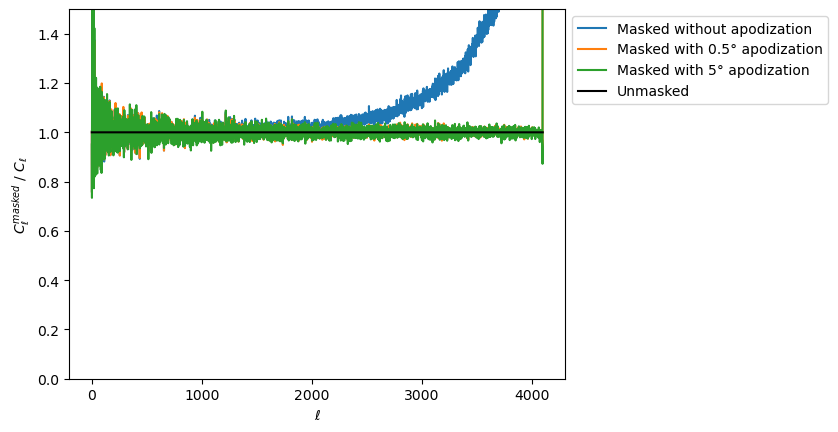

In [26]:
plt.plot(ell[ellmin:], ratio_1[ellmin:], label = 'Masked without apodization')
plt.plot(ell[ellmin:], ratio_2[ellmin:], label = f'Masked with 0.5{degree_symbol} apodization')
plt.plot(ell[ellmin:], ratio_3[ellmin:], label = f'Masked with 5{degree_symbol} apodization')
plt.plot(ell[ellmin:], ratio[ellmin:], c = 'black', label = 'Unmasked')
plt.xlabel(r'$\ell$')
plt.ylim(0, 1.5)
plt.ylabel(r'$C^{masked}_\ell$ / $C_\ell$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

White Noise

In [3]:
def noise_level2noise_multipole(epsilon, lmax):
    epsilon_l = epsilon**2 * (np.pi/60/180)**2
    return epsilon_l * np.ones(lmax+1)

def noise_level2noise_pixel(epsilon, reso):
    epsilon_pix = epsilon/reso
    return epsilon_pix

In [4]:
kdegree2mukarcmin = 1e6*60
detector = 100
Freq_100Ghz_noise_level = WHITE_NOISE_LEVELS[detector]*60

In [7]:
nl = noise_level2noise_multipole(Freq_100Ghz_noise_level, ellmax)
reso = hp.nside2resol(nside, arcmin=True)
nl_pixel = noise_level2noise_pixel(Freq_100Ghz_noise_level, reso)

In [8]:
new_reso = hp.nside2resol(512, arcmin=True)
nl_pixel_new = noise_level2noise_pixel(Freq_100Ghz_noise_level, new_reso)
print(nl_pixel_new, nl_pixel)

11.264780401074946 45.05912160429978


In [3]:
planck_noise_path = {'30' : '/home/yunan/planck_release/ffp10_noise_030_full_map_mc_00000.fits',
                     '100': '/home/yunan/planck_release/ffp10_noise_100_full_map_mc_00000.fits',
                     '143': '/home/yunan/planck_release/ffp10_noise_143_full_map_mc_00000.fits'}
planck_noise_map = {}
planck_noise_map_Q = {}
planck_noise_map_U = {}
frequency = ['30', '100', '143']
for frequency in planck_noise_path:
    planck_noise_map[frequency] = hp.read_map(planck_noise_path[frequency])*1e6
    planck_noise_map_Q[frequency] = hp.read_map(planck_noise_path[frequency], field=1)*1e6
    planck_noise_map_U[frequency] = hp.read_map(planck_noise_path[frequency], field=2)*1e6

In [37]:
IQU_fields = ['I', 'Q', 'U']
Planck_noise_sim = {}
for freq in planck_noise_path:
    for IQU_field in IQU_fields:
        Planck_noise_sim[f"{freq}_{IQU_field}"] = hp.read_map(planck_noise_path[freq], field=IQU_fields.index(IQU_field))*1e6


In [42]:
Planck_noise_sim

{'30_I': array([ 92.88243 , -35.481598,  13.510813, ...,  41.490955, -54.365356,
        -23.069115], dtype=float32),
 '30_Q': array([-160.41008 , -131.13629 ,   -8.882167, ...,   76.71052 ,
         -64.315155,  -62.950115], dtype=float32),
 '30_U': array([  38.644905, -129.41571 ,   65.80028 , ...,   60.984806,
         -55.669903,  -50.862526], dtype=float32),
 '100_I': array([ 14.221001,  -8.869833, -51.37522 , ...,  51.994556,  17.589842,
        -54.58973 ], dtype=float32),
 '100_Q': array([-83.65902  ,  -2.9591808, -58.953613 , ...,  33.107876 ,
          8.566303 ,   9.854566 ], dtype=float32),
 '100_U': array([ -0.7710572,  20.87055  ,  10.276699 , ..., -61.108753 ,
        -51.713978 ,  45.272217 ], dtype=float32),
 '143_I': array([ -4.1640306,   1.487424 ,  10.541596 , ..., -30.156582 ,
         25.338938 ,   5.3756886], dtype=float32),
 '143_Q': array([-12.549065 ,  25.844664 ,  60.748344 , ..., -18.691217 ,
         -0.6703573, -97.573845 ], dtype=float32),
 '143_U': array

In [47]:
# Calculate noise co-variance matrix for each frequency
noise_cov = {}
for freq in planck_noise_path:
    for IQU_field_1 in IQU_fields:
        for IQU_field_2 in IQU_fields[IQU_fields.index(IQU_field_1):]:
            noise_map_1 = Planck_noise_sim[f"{freq}_{IQU_field_1}"]
            noise_map_2 = Planck_noise_sim[f"{freq}_{IQU_field_2}"]
            noise_cov[f'{freq}_{IQU_field_1}_{IQU_field_2}'] = hp.anafast(noise_map_1, noise_map_2, lmax=ellmax)
            print(f"Noise covariance for {freq} {IQU_field_1} and {freq} {IQU_field_2}: {noise_cov[f'{freq}_{IQU_field_1}_{IQU_field_2}']}")



is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?

Noise covariance for 30 I and 30 I: [1.42441441e+03 6.54637803e-02 2.86675705e+03 ... 6.48676571e-01
 6.17892165e-01 6.11657620e-01]

is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?

Noise covariance for 30 I and 30 Q: [ 1.88384212e+01 -1.42680149e-02  3.16969471e+00 ... -4.84399368e-03
 -2.12009284e-03 -3.36824643e-03]

is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you

In [63]:
# Reforging the covariance matrix that covariance matrix for each frequency detector is 3x3 for ellmax+1
def get_noise_covariance_matrix(freq):
    noise_cov_matrix = np.zeros((3, 3, ellmax+1))
    for IQU_field_1 in IQU_fields:
        for IQU_field_2 in IQU_fields[IQU_fields.index(IQU_field_1):]:
            key = f'{freq}_{IQU_field_1}_{IQU_field_2}'
            if key in noise_cov:
                noise_cov_matrix[IQU_fields.index(IQU_field_1), IQU_fields.index(IQU_field_2), :] = noise_cov[key]
                # Fill the symmetric part
                if IQU_field_1 != IQU_field_2:
                    noise_cov_matrix[IQU_fields.index(IQU_field_2), IQU_fields.index(IQU_field_1), :] = noise_cov[key]
    return noise_cov_matrix

# Calculate the noise covariance matrix for each frequency
noise_cov_matrices = {}
for freq in planck_noise_path:
    noise_cov_matrices[freq] = get_noise_covariance_matrix(freq)

In [64]:
# Check the 100 GHz noise covariance matrix for ellmax = 100
noise_cov_matrices['100'][:, :, 100]

array([[ 2.61450099e-04, -7.22354354e-05, -5.67896018e-06],
       [-7.22354354e-05,  7.28270191e-04, -1.94438124e-05],
       [-5.67896018e-06, -1.94438124e-05,  6.87609503e-04]])

In [65]:
# Convert the 3x3 noise covariance matrix to maps using synfast
def synfast_noise_covariance_matrix(freq, nside):
    noise_cov_matrix = noise_cov_matrices[freq]
    noise_map = np.zeros((3, hp.nside2npix(nside)))
    for i in range(3):
        for j in range(3):
            cl = noise_cov_matrix[i, j, :]
            noise_map[i] += hp.synfast(cl, nside=nside, new=True)
    return noise_map

# Generate noise maps for each frequency
noise_maps_cov_matrix = {}
for freq in planck_noise_path:
    noise_maps_cov_matrix[freq] = synfast_noise_covariance_matrix(freq, nside)

In [6]:
# Using 3 maps at the same time to calculate covariance matrix
test_map = hp.read_map(planck_noise_path['100'], field = (0 ,1 ,2))

In [70]:
test_cov = hp.anafast(test_map, lmax=ellmax)

In [72]:
test_cov

array([[ 2.76309765e-13,  1.15667339e-13,  2.86787374e-14, ...,
         5.30978486e-16,  5.41842179e-16,  5.48614265e-16],
       [ 0.00000000e+00,  0.00000000e+00,  2.73647255e-14, ...,
         1.22549745e-15,  1.21354640e-15,  1.27474231e-15],
       [ 0.00000000e+00,  0.00000000e+00,  1.10934016e-13, ...,
         1.20927501e-15,  1.20356968e-15,  1.21243268e-15],
       [ 0.00000000e+00,  0.00000000e+00, -2.67596847e-14, ...,
        -1.79811605e-17,  1.93594881e-18,  1.12216700e-17],
       [ 0.00000000e+00,  0.00000000e+00, -9.66727397e-15, ...,
        -7.76593592e-18, -2.34157454e-17, -1.67635759e-17],
       [ 0.00000000e+00,  0.00000000e+00,  1.59918373e-14, ...,
         7.10139632e-18,  4.69541776e-19,  4.37667776e-18]])

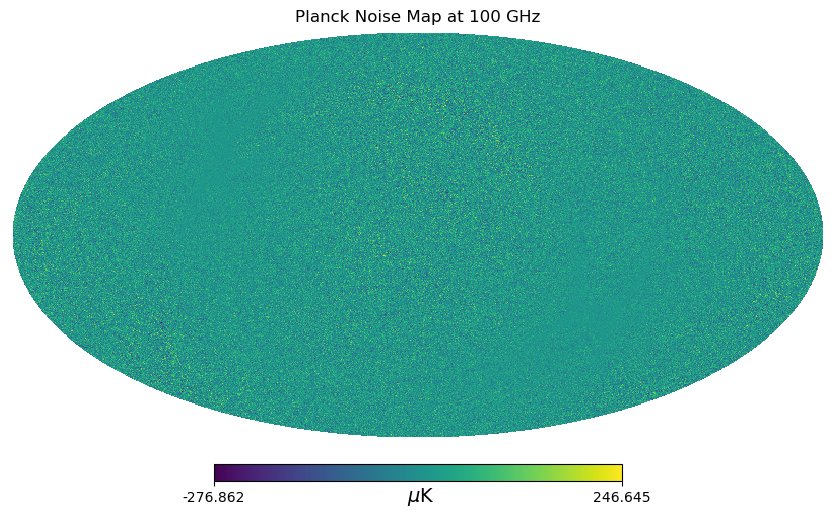

In [75]:
hp.mollview(planck_noise_map['100'], title="Planck Noise Map at 100 GHz", unit=" $\\mu$K")

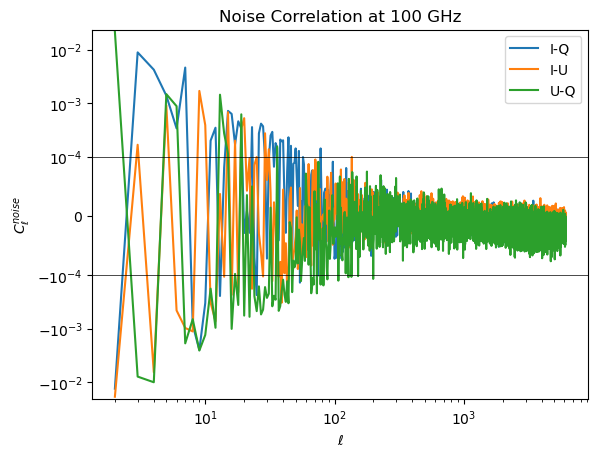

In [21]:
ellmin = 2
linthresh = 1e-4

# Plot the 100 GHz noise corrleations
plt.plot(ell[ellmin:], nl_IQ_Planck_100[ellmin:], label='I-Q')
plt.plot(ell[ellmin:], nl_IU_Planck_100[ellmin:], label='I-U')
plt.plot(ell[ellmin:], nl_UQ_Planck_100[ellmin:], label='U-Q')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{noise}$')
plt.xscale('log')
plt.yscale('symlog', linthresh=linthresh)
plt.axhline(linthresh, color='black', lw=0.5)
plt.axhline(-linthresh, color='black', lw=0.5)
# plt.xlim(2, ellmax)
plt.title("Noise Correlation at 100 GHz")
plt.legend()
plt.show()

In [49]:
nl_planck = {}
nl_planck_Q = {}
nl_planck_U = {}
nl_pixel_planck = {}
for frequency in planck_noise_map:
    nl_planck[frequency] = hp.anafast(planck_noise_map[frequency], lmax=ellmax)
    nl_planck_Q[frequency] = hp.anafast(planck_noise_map_Q[frequency], lmax=ellmax)
    nl_planck_U[frequency] = hp.anafast(planck_noise_map_U[frequency], lmax=ellmax)
    nl_pixel_planck[frequency] = np.std(planck_noise_map[frequency])


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?



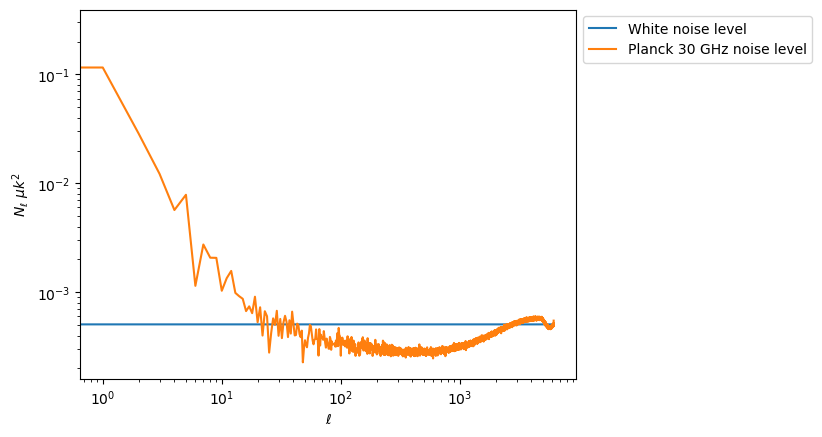

In [11]:
plt.plot(ell[ellmin:], nl[ellmin:], label = 'White noise level')
plt.plot(ell[ellmin:], nl_planck['100'][ellmin:], label = 'Planck 30 GHz noise level')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$N_\ell$ $\mu k^2$')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [12]:
nl_pixel_planck

{'30': 57.655594, '100': 46.027393, '143': 19.966099}

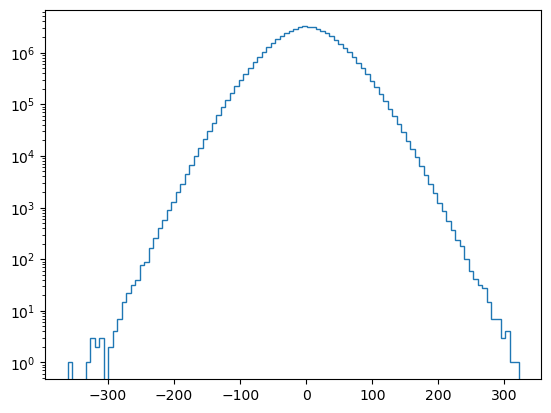

In [86]:
plt.hist(planck_noise_map['100'], bins=100, histtype='step', label='30 GHz')
plt.yscale('log')

In [36]:
three_sigma = {}
for frequency in planck_noise_map:
    three_sigma[frequency] = np.mean(planck_noise_map[frequency]) + 5*np.std(planck_noise_map[frequency])

In [37]:
three_sigma

{'30': 304.24932384490967, '100': 230.28525020182133, '143': 99.90375799685717}

Now we downgrade the noise map to $N_{side}$ = 512

In [12]:
nside_new = 512
ellmax_new = 3*nside_new - 1
reso_new = hp.nside2resol(nside_new, arcmin=True)

We still have the same noise_level per arcminute

In [16]:
Freq_100Ghz_noise_level_new = WHITE_NOISE_LEVELS[detector]*kdegree2mukarcmin
nl_new = noise_level2noise_multipole(Freq_100Ghz_noise_level_new, ellmax_new)/1e12
nl_pixel_new = noise_level2noise_pixel(Freq_100Ghz_noise_level_new, reso_new)

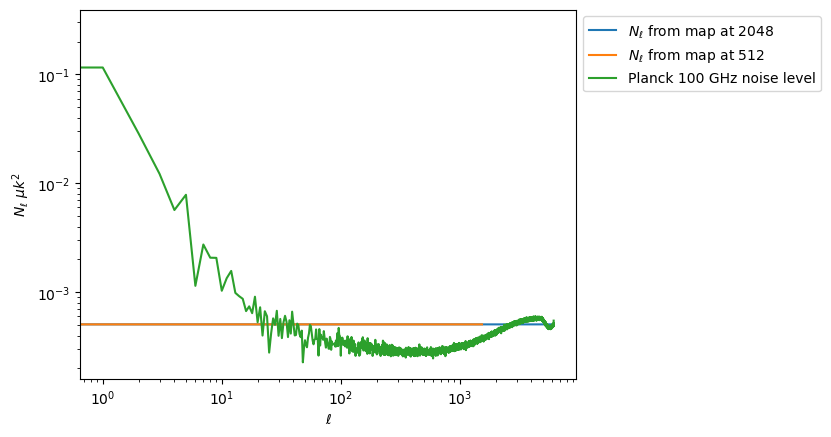

In [17]:
plt.plot(ell[ellmin:], nl[ellmin:], label = '$N_\\ell$ from map at 2048')
plt.plot(np.arange(ellmax_new+1), nl_new, label = '$N_\\ell$ from map at 512')
plt.plot(ell[ellmin:], nl_planck['100'][ellmin:], label = 'Planck 100 GHz noise level')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$N_\ell$ $\mu k^2$')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [41]:
print(f"Pixel noise level at 2048: {nl_pixel}")
print(f"Pixel noise level at 512: {nl_pixel_new}")

Pixel noise level at 2048: 218.452786125428
Pixel noise level at 512: 54.613196531357


Check the map

In [42]:
wn_map_at_512 = hp.synfast(nl_new, nside=nside_new, new=True)
wn_map_at_2048 = hp.synfast(nl, nside=nside, new=True)

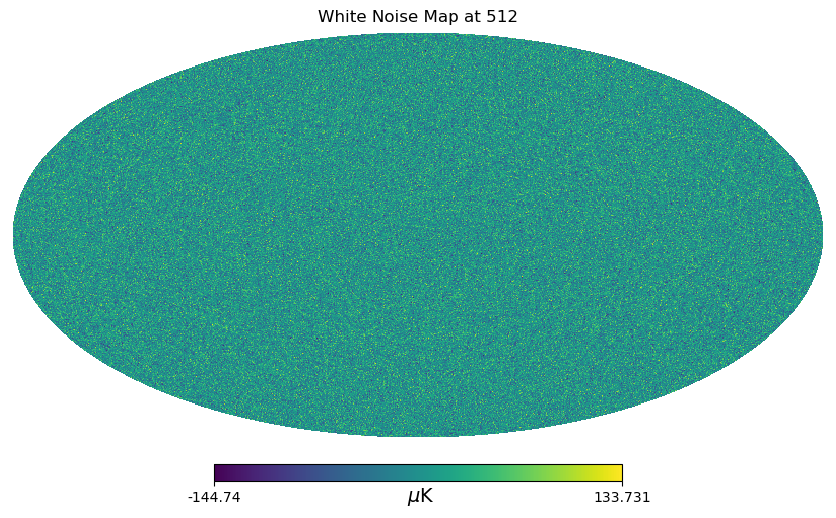

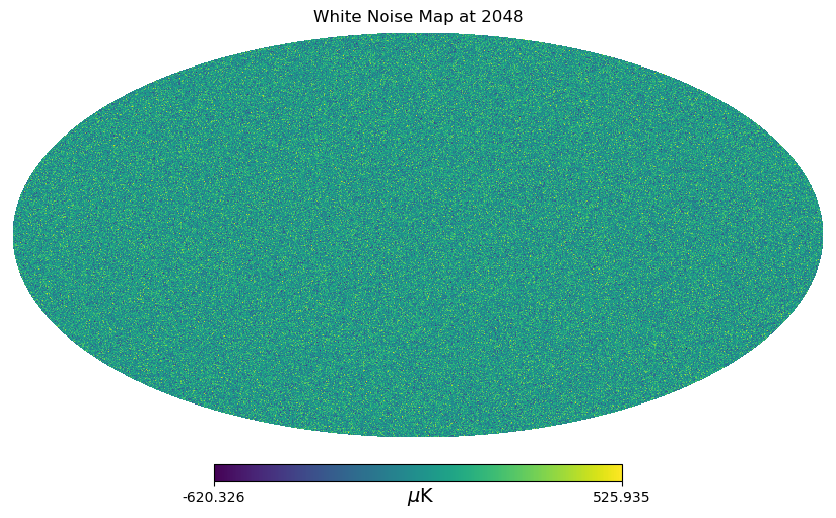

In [43]:
hp.mollview(wn_map_at_512, title="White Noise Map at 512", unit=" $\\mu$K")
hp.mollview(wn_map_at_2048, title="White Noise Map at 2048", unit=" $\\mu$K")


Try to downgrade the noise map in harmonic space

In [44]:
def get_alms(map_in):
    nside_in = hp.get_nside(map_in)
    lmax_in = 2*nside_in
    alm = hp.map2alm(map_in, lmax = lmax_in)
    return alm

def alm_udgrade(map_in, nside_out):
    alm_in = get_alms(map_in)
    lmax_out = 2*nside_out 
    alm_out = hp.almxfl(alm_in, np.ones(lmax_out + 1))
    map_out = hp.alm2map(alm_out, nside_out)
    return map_out

In [45]:
alm_from_2048 = hp.map2alm(wn_map_at_2048, lmax=ellmax)
wn_map_at_512_new = alm_udgrade(wn_map_at_2048, nside_new)

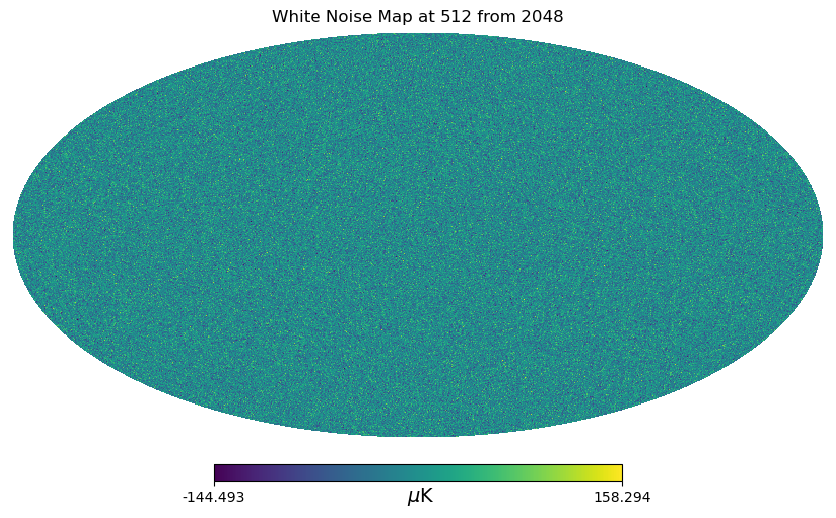

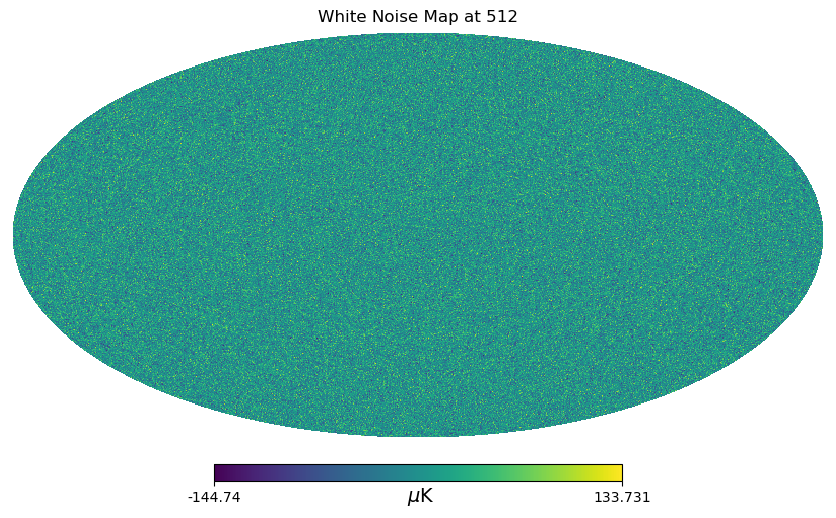

In [46]:
hp.mollview(wn_map_at_512_new, title="White Noise Map at 512 from 2048", unit=" $\\mu$K")
hp.mollview(wn_map_at_512, title="White Noise Map at 512", unit=" $\\mu$K")

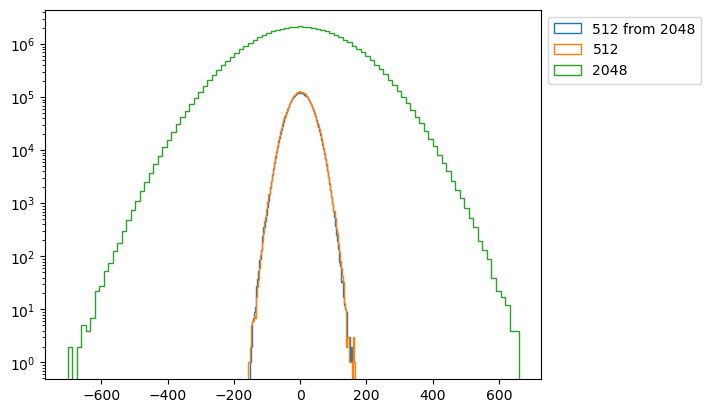

In [47]:
plt.hist(wn_map_at_512_new, bins=100, histtype='step', label='512 from 2048')
plt.hist(wn_map_at_512, bins=100, histtype='step', label='512')
plt.hist(wn_map_at_2048, bins=100, histtype='step', label='2048')
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [48]:
nl_at_512_new = hp.anafast(wn_map_at_512_new, lmax=ellmax_new)

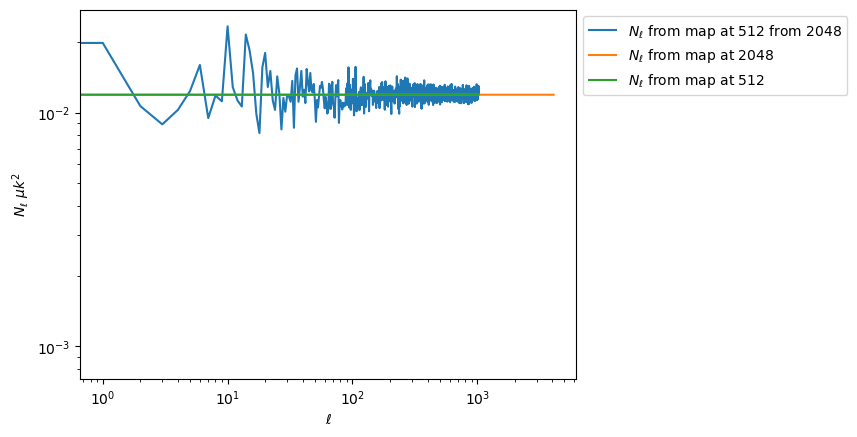

In [58]:
plt.plot(np.arange(ellmax_new+1), nl_at_512_new, label = '$N_\\ell$ from map at 512 from 2048')
plt.plot(ell, nl, label = '$N_\\ell$ from map at 2048')
plt.plot(np.arange(ellmax_new+1), nl_new, label = '$N_\\ell$ from map at 512')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$N_\ell$ $\mu k^2$')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


If the CMB map still have some level of noise

In [50]:
residual_noise_level = 23 # muK_CMB arcmin

# For 2048
residual_noise_level_pixel = noise_level2noise_pixel(residual_noise_level, reso)
residual_noise_multipole = noise_level2noise_multipole(residual_noise_level, ellmax)

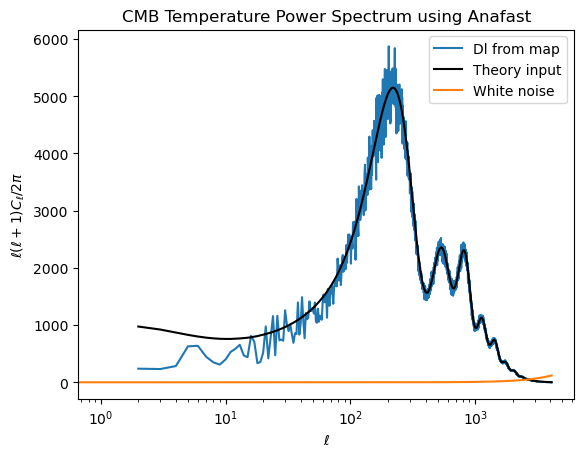

In [51]:
plt.plot(ell[ellmin:], dls_from_map, label = 'Dl from map')
plt.plot(ell[ellmin:], totCL[ellmin:, 0], c = 'black',label = 'Theory input')
plt.plot(ell, residual_noise_multipole*ell*(ell+1)/2/np.pi, label = 'White noise')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell (\ell + 1) C_\ell / 2\pi$')
plt.xscale('log')
plt.title("CMB Temperature Power Spectrum using Anafast")
plt.legend()
plt.show()
